# Creating BDT input pkls from input ntuples

as well as the final pkls for use in the main analysis.

The purpose of this notebooke was to see if the updated NuMI flux ntuples could be ported into the main analysis body, and the effect this would have.

In [1]:
# So that the notebook us updated to reflect changes in the .py file:
%load_ext autoreload
%autoreload 2
from create_pkls import * # .py file used to define most functions

## Creating a pickle for the main variables defined in create_pkls.py

Main does NOT include the ppfx and other weights, as the root tree cannot be flattened otherwise.
3_Genie_background.ipynb has example functions for how they should be saved separately.


They selected into a separate dataframe and merged with the main, saved as a complete pkl.

In [80]:
# Checking whether this code works with the original detsys files 
detvar_ntuple_path = '/exp/uboone/data/users/kmistry/work/MCC9/searchingfornues/ntuple_files_detvar_newtune/run3/'
filename_root = 'neutrinoselection_filt_run3_overlay_detvar_'
name_extention = 'LYAttenuation.root' # Other examples are given at the bottom of this notebook

Sample POT: 3.312e+20


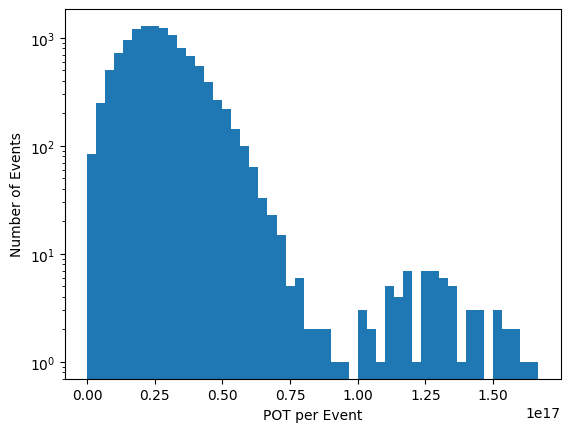

Created main dataframe.
File path: /exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/NewFlux/BDT_input_pkl/
pkl name: AllVar_UnSelected_Run3_NuMI_detsys_old_Weights_Updated_Flux


In [79]:
# Parameters to set so that files are saved/imported correctly
run = 'Run3' # Currently only Run3 ntuple
sample = 'detsys_old' # 'Data', 'Signal', 'Overlay', 'Dirt', 'EXT'

# Defining the pkl save path
loc_BDT_input = '/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/NewFlux/BDT_input_pkl/'

# Import the ntuples you want to process and produce pkls for.
# Currently using a copy of the update NuMI flux pelee sample
loc_ntuple = '/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/NewFlux/' 


# loc_ntuple  = '/exp/uboone/data/users/kmistry/work/MCC9/searchingfornues/ntuple_files_detvar_newtune/run3/' # Old detvar location   


ntuple_name =  filename_root+name_extention # 'numi_nu_pelee_ntuples_run3_rhc_g4.10.4_full.root'

# Alternative path - using patricks origanl copy
ntuple_path = '/exp/uboone/data/users/pgreen/standard_pelee_ntuples/alternative_flux_g4.10.4/numi_nu_pelee_ntuples_run3_rhc_g4.10.4_full.root'

remake_pkl = True # If True, will remake the background pkl file. 
if remake_pkl:
    
    root_tree = uproot.open(loc_ntuple + ntuple_name)['nuselection;1']
    # Retrieving the POT information from the SubRun tree
    pot_df = root_tree['SubRun'].pandas.df()

    root_tree = root_tree['NeutrinoSelectionFilter']

    print('Sample POT: {:.4}'.format(sum(pot_df['pot'])))

    plt.hist(pot_df['pot'], bins=50)

    plt.yscale('log')
    plt.xlabel('POT per Event')
    plt.ylabel('Number of Events')
    plt.show()

    additional_variables = mc_variables+weights_variables
    
    # Option to add extra variables to main/additional arrays, based on the sample type.
    if sample == 'Overlay':
        Main_variables += ["ppfx_cv"]
    
    df_main_vars = root_tree.pandas.df(Main_variables,flatten=True) # Cannot do main & weights/MC vars combined, as weights & MC can't be flattened!
    print('Created main dataframe.')
    df_jagged_vars = root_tree.pandas.df(additional_variables, flatten=False)

    df_all_vars = pd.merge(df_main_vars, df_jagged_vars, on='entry', how='inner')

    df_all_vars.to_pickle(loc_BDT_input+f'AllVar_UnSelected_{run}_NuMI_{sample}_Weights_Updated_Flux.pkl') # Saving the main variables and weights to a pkl file for quicker loading
    print(f'File path: {loc_BDT_input}')
    print(f'pkl name: AllVar_UnSelected_{run}_NuMI_{sample}_Weights_Updated_Flux')
    

## Creating separate 1 shower and 2 shower samples

and saving them for access later.

In [83]:
sample_pkl = f'AllVar_UnSelected_{run}_NuMI_{sample}_Weights_Updated_Flux.pkl'

df_temp = pd.read_pickle(loc_BDT_input+sample_pkl) # Loading the main variables and weights from the pkl file

df_temp_new = df_temp.copy()
df_temp_1shr = preselection_1shr(df_temp_new, print_bool=True)
print('final')
print(len(df_temp_1shr['run']))
df_temp_1shr = get_1shr_variable (df_temp_1shr.copy())
df_temp_1shr = merge_true_theta_bkg(df_temp_1shr.copy(), 'Run3')
df_temp_1shr = tag_bkg_category(df_temp_1shr.copy(), 'o') # o: overlay, d: dirt, e: ext

df_temp_1shr.to_pickle(loc_BDT_input+f'AllVar_Selected_{run}_NuMI_{sample}_Weights_1shr_Updated_Flux.pkl')



df_temp_new = df_temp.copy()
df_temp_2shr = preselection_2shr(df_temp_new, print_bool=True)
df_temp_2shr = leading_shr(df_temp_2shr.copy())
df_temp_2shr = get_2shr_variable (df_temp_2shr.copy())
df_temp_2shr = merge_true_theta_bkg(df_temp_2shr.copy(), 'Run3')
df_temp_2shr = tag_bkg_category(df_temp_2shr.copy(), 'o') # o: overlay, d: dirt, e: ext
df_temp_2shr.to_pickle(loc_BDT_input+f'AllVar_Selected_{run}_NuMI_{sample}_Weights_2shr_Updated_Flux.pkl')

Before FV cut
150033
After FV cut
111625
After nu_purity_from_pfp cut
111625
After CRT cut
82605
After trk_score cut
21765
After shr_pfp_id_v cut
19507
After n_showers_contained_MCStool cut
6960
After Counts==1 cut
6124


/exp/uboone/app/users/jbateman/workdir/HPS_uboone_analysis/BDT_pkl_gen/create_pkls.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_ID"] = df["run"].apply(str) +"_"+ df["sub"].apply(str) +"_"+ df["evt"].apply(str)
/exp/uboone/app/users/jbateman/workdir/HPS_uboone_analysis/BDT_pkl_gen/create_pkls.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Counts'] = df.groupby(['entry'])['temp_ID'].transform('count')


final
6124


/exp/uboone/app/users/jbateman/workdir/HPS_uboone_analysis/BDT_pkl_gen/create_pkls.py:377: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.6 8.6]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_new.loc[(df_new['theta_nu']>=2.14) & (df_new['nu_e_ls']>=0.2354) & (df_new['nu_e_ls']<=0.2356), ['KDAR_scale']] *= KDAR_factor


After FV cut
111625
After nu_purity_from_pfp cut
111625
After FV cut
111625
After CRT cut
82605
After trk_score cut
21765
After shr_pfp_id_v cut
19507
After n_showers_contained_MCStool cut
5721
After Counts==2 cut
5160


/exp/uboone/app/users/jbateman/workdir/HPS_uboone_analysis/BDT_pkl_gen/create_pkls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_ID"] = df["run"].apply(str) +"_"+ df["sub"].apply(str) +"_"+ df["evt"].apply(str)
/exp/uboone/app/users/jbateman/workdir/HPS_uboone_analysis/BDT_pkl_gen/create_pkls.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Counts'] = df.groupby(['entry'])['temp_ID'].transform('count')
/exp/uboone/app/users/jbateman/workdir/HPS_uboone_analysis/BDT_pkl_gen/create_pk

2580
2581
2579
2579
df
5160
df_temp_temp
2
2580
2580
2580
2580


/exp/uboone/app/users/jbateman/workdir/HPS_uboone_analysis/BDT_pkl_gen/create_pkls.py:377: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.6]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_new.loc[(df_new['theta_nu']>=2.14) & (df_new['nu_e_ls']>=0.2354) & (df_new['nu_e_ls']<=0.2356), ['KDAR_scale']] *= KDAR_factor


## Now we need to get the predictions from each BDT

and assign is_trained = 0 for each point (I think both Nu overlay and signal are independent samples from the original training dataset). 

In [84]:
BDT_path = '/exp/uboone/data/users/jbateman/workdir/aadi/jupyter_koto/Booster2sens/'

# /Run1_150_MeV_NEW/BDT_models/BDT_Model_Top_14_features_Run1_150_MeVKDIF_1shr_Final_Main_BDT'
# AllVar_Selected_Run3_NuMI_Overlay_1shr_Updated_Flux
runs = ['Run3']
mass_points = ['100_MeV', '125_MeV', '130_MeV', '135_MeV','140_MeV', '145_MeV', '150_MeV', '200_MeV']
kaons = ['KDIF', 'KDAR']
shrs = ['1shr','2shr']

dict_df = {}
print(f'File path: {loc_BDT_input}')

k = kaons[0]
mass = mass_points[0]
shr = shrs[0]
print(f'Example file name: AllVar_Selected_{run}_NuMI_{sample}_{k}_{mass}_{shr}_Weights_Updated_Flux_pred.pkl')

create_final_overlay_pkls = True
if create_final_overlay_pkls:
    for run in runs:    
        for k in kaons:
            for mass in mass_points:
                for shr in shrs:
                    df_temp = pd.read_pickle(loc_BDT_input+f'AllVar_Selected_{run}_NuMI_{sample}_Weights_{shr}_Updated_Flux.pkl')

                    BDT_name = f"/{run}_{mass}_NEW/BDT_models/BDT_Model_Top_14_features_{run}_{mass}{k}_{shr}_Final_Main_BDT"
                    booster = joblib.load(BDT_path + BDT_name)
                    print(f"{run}_{mass}_{k}_{shr}")
                    print(len(df_temp['run_ls']))
                    cols_for_booster = booster.feature_names
                    
                    untrnd_df = df_temp[cols_for_booster].copy()
                    feature_names = untrnd_df.columns.to_list()
                    untrnd_final = xgboost.DMatrix(data=untrnd_df[feature_names],missing=-999.0,feature_names=feature_names)
                    
                    pred = booster.predict(untrnd_final)
                    print('Calculated predictions...')

                    df_temp = df_temp.copy()
                    df_temp['pred'] = pred
                    
                    cols_to_use  = ['weightsPPFX_ls', 'weightsGenie_ls', 'weightsReint_ls']
                    if shr == '2shr': 
                        cols_to_drop = ['weightsPPFX_sls', 'weightsGenie_sls', 'weightsReint_sls']
                        df_temp = df_temp.drop(cols_to_drop, axis=1)
                    
                    df_temp = df_temp.rename(columns={'weightsPPFX_ls': 'weightsPPFX',
                                    'weightsGenie_ls': 'weightsGenie',
                                    'weightsReint_ls': 'weightsReint',
                                    # Renaming these params for parity with old pkl files
                                    'mc_px_ls': 'mc_primary_px_ls',
                                    'mc_py_ls': 'mc_primary_py_ls',
                                    'mc_pz_ls': 'mc_primary_pz_ls',
                                    'mc_px_sls': 'mc_primary_px_sls',
                                    'mc_py_sls': 'mc_primary_py_sls',
                                    'mc_pz_sls': 'mc_primary_pz_sls',
                                    'mc_pdg_ls': 'mc_primary_pdg_ls',
                                    'mc_pdg_sls': 'mc_primary_pdg_sls'
                                    })
                    
                    df_temp['is_trained'] = 0
                    df_temp['run'] = df_temp['run_ls']
                    df_temp['sub'] = df_temp['sub_ls']
                    df_temp['evt'] = df_temp['evt_ls']
                    df_temp['nslice'] = df_temp['nslice_ls']
                    print('Fixed column labelling...')
                    # Calculating these parameters early, to save so much time on importing these pkls later
                    if sample == 'Overlay':
                        df_temp['thsnd_weight_genie'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_temp['weightsGenie']])
                        df_temp['thsnd_weight_ppfx'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_temp['weightsPPFX']])
                        df_temp['thsnd_weight_reint'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_temp['weightsReint']])
                        
                        df_temp['inf_weight_genie'] = (['yes' if any(a>65534 for a in i) else 'no' for i in df_temp['weightsGenie']])
                        df_temp['inf_weight_ppfx'] = (['yes' if any(a>65534 for a in i) else 'no' for i in df_temp['weightsPPFX']])
                        df_temp['inf_weight_reint'] = (['yes' if any(a>65534 for a in i) else 'no' for i in df_temp['weightsReint']])

                        df_temp['ones_weight_genie'] = (['yes' if all(a == 1 for a in i) else 'no' for i in df_temp['weightsGenie']])
                        df_temp['ones_weight_ppfx'] = (['yes' if all(a == 1 for a in i) else 'no' for i in df_temp['weightsPPFX']])
                        df_temp['ones_weight_reint'] = (['yes' if all(a == 1 for a in i) else 'no' for i in df_temp['weightsReint']])
                        
                        df_temp['zero_weight_genie'] = (['yes' if all(a == 0 for a in i) else 'no' for i in df_temp['weightsGenie']])
                        df_temp['zero_weight_ppfx'] = (['yes' if all(a == 0 for a in i) else 'no' for i in df_temp['weightsPPFX']])
                        df_temp['zero_weight_reint'] = (['yes' if all(a == 0 for a in i) else 'no' for i in df_temp['weightsReint']])
                        print('Calculated PPFX, Genie, Reint flags...')
                    
                    df_temp.to_pickle(loc_BDT_input+f'AllVar_Selected_{run}_NuMI_{sample}_{k}_{mass}_{shr}_Weights_Updated_Flux_pred.pkl')
                    print('Saved pkl file...')
                    print(f'File name: AllVar_Selected_{run}_NuMI_{sample}_{k}_{mass}_{shr}_Weights_Updated_Flux_pred.pkl')
                    dict_df[f"{run}_{mass}_{k}_{shr}"] = df_temp
                print()



File path: /exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/NewFlux/BDT_input_pkl/
Example file name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_100_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:27] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:27] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_100_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_100_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:31] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_100_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_100_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:32] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_125_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_125_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:33] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_125_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_125_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:34] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_130_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_130_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:36] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_130_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_130_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:37] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_135_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_135_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:39] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_135_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_135_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:40] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_140_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_140_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:41] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_140_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_140_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:42] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_145_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_145_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:47] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_145_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_145_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:48] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_150_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_150_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:49] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_150_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_150_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:51] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_200_MeV_KDIF_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_200_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:52] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_200_MeV_KDIF_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDIF_200_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:53] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_100_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_100_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:54] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_100_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_100_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:55] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_125_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_125_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:56] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_125_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_125_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:57] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_130_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_130_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:59] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_130_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_130_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:16:59] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_135_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_135_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:00] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_135_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_135_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:01] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_140_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_140_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:03] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_140_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_140_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:03] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_145_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_145_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:04] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_145_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_145_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:05] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_150_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_150_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:06] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_150_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_150_MeV_2shr_Weights_Updated_Flux_pred.pkl



/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:08] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_200_MeV_KDAR_1shr
6124
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_200_MeV_1shr_Weights_Updated_Flux_pred.pkl


/nashome/j/jbateman/miniconda3/envs/HPS_ana/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:17:09] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Run3_200_MeV_KDAR_2shr
2580
Calculated predictions...
Fixed column labelling...
Saved pkl file...
File name: AllVar_Selected_Run3_NuMI_detsys_old_KDAR_200_MeV_2shr_Weights_Updated_Flux_pred.pkl



## Correctly processing universes

Note that 'fix_universes' function is incorporated into Loading_pkls_test.ipynb

As the genie, PPFX and reint weights are incorporated, matching event, I think the weights are working.
Detsys samples will need to be generated though (I think - look into this!)!

## Creating the final BDT score pkls
 
Firstly, by finding what keys we are missing!

Now we can merge these into the final pkls to input into our analysis code.
Aditya's 3_Genie_background.ipynb appears to be merging the EXT, dirt and overlay into a single file, but that is not what is used in the final analysis.

In [8]:
run_test = 'Run3'
sample_test = 'Overlay'
k_test = 'KDAR'
mass_test = '100'
shr_test = '1shr'

loc_old_pkls = '/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/BDT_inputs_pkl/'
filename_test = f"AllVar_Selected_{run_test}_NuMI_{sample_test}_{k_test}_{mass_test}_{shr_test}_PPFX_pred_NEW"
old_df = pd.read_pickle(loc_old_pkls+f"{filename_test}.pkl")
keys_old = old_df.keys().to_list()




new_df = pd.read_pickle(loc_BDT_input+f'AllVar_Selected_{run_test}_NuMI_{sample_test}_{k_test}_{mass_test}_MeV_{shr_test}_Weights_Updated_Flux_pred.pkl')
keys_new = new_df.keys().to_list()

missing_keys = list(set(keys_old) - set(keys_new))

In [9]:
missing_from_old = []
missing_from_new = []

for key in missing_keys:

    if key in keys_old:
        missing_from_new.append(key)
    elif key in keys_new:
        missing_from_old.append(key)
    else:
        print(f"something strange with key: {key}")

In [13]:
print('Missing from new \n')
print(missing_from_new)
print('Missing from old \n')
print(missing_from_old)

print(f'Total missing: {len(missing_keys)}')

Missing from new 

['temp_ID', 'ppfx_cv', 'is_good']
Missing from old 

[]
Total missing: 3


## Testing whether this pkl imports correctly
by using a cut-down version of the New_loader function

In [14]:
run_test = 'Run3'
sample_test = 'Overlay'
k_test = 'KDIF'
mass_test = '150'
shr_test = '1shr'

df_ovl = New_loader(run_test, mass_test, shr_test, k_test)
df_old = New_loader_OLD(run_test, mass_test, shr_test, k_test)

SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '150', '1shr', 'KDIF')
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '150', '1shr', 'KDIF')


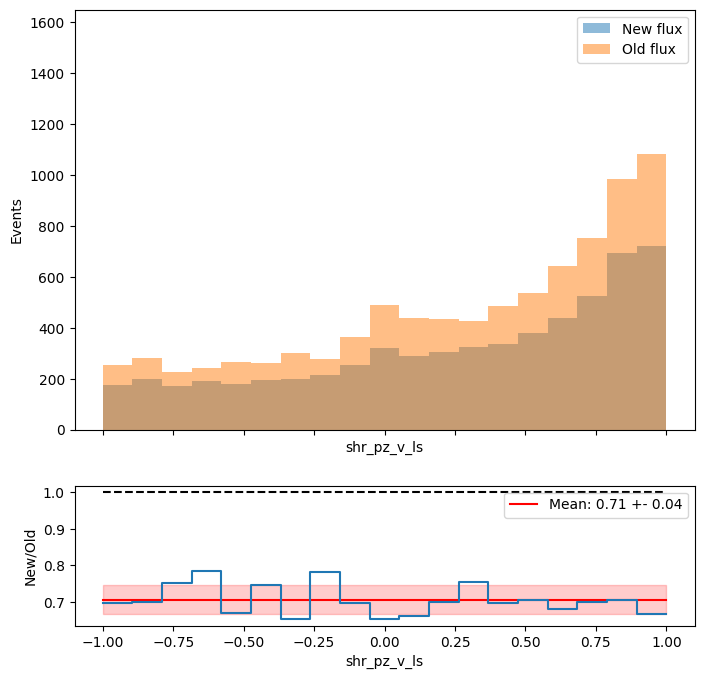

In [56]:
feature = 'shr_pz_v_ls'
 

bins = np.linspace(-1,1,20)
fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,8),dpi=100)
plt.sca(ax[0])

weight_Overlay = df_ovl['scale_factor_ls']*df_ovl['ppfx_cv_ls']
plt.hist(df_ovl[feature], weights=weight_Overlay, bins = bins, alpha = 0.5, label='New flux',density=False)

weight_Overlay_old = df_old['scale_factor_ls']*df_old['ppfx_cv_ls']
plt.hist(df_old[feature], weights=weight_Overlay_old, bins=bins, alpha=0.5, label='Old flux',density=False)
plt.xlabel(feature)
plt.ylabel('Events')
plt.legend()
plt.ylim(0,1650)
# plt.yscale('log')

hist_new, bins = np.histogram(df_ovl[feature], weights=weight_Overlay, bins = bins,density=False)
hist_old, bins = np.histogram(df_old[feature], weights=weight_Overlay_old, bins=bins, density=False)
hist_ratio = hist_new/hist_old

mean_ratio = np.mean(hist_ratio)
std_ratio = np.std(hist_ratio)

bin_centres = (bins[1:] - bins[:-1])/2 + (bins[:-1])

hist_step, bins_step = format_for_step(hist_ratio, bins)
plt.sca(ax[1])
plt.plot([np.min(bins_step), np.max(bins_step)],[1,1], 'k--')
plt.plot([np.min(bins_step), np.max(bins_step)], [mean_ratio,mean_ratio], 'r', label=f'Mean: {mean_ratio:.2f} +- {std_ratio:.2f}')
plt.fill_between([np.min(bins_step), np.max(bins_step)], [mean_ratio-std_ratio, mean_ratio-std_ratio], [mean_ratio+std_ratio, mean_ratio+std_ratio], color='r', alpha=0.2)
plt.step(bins_step,hist_step)

plt.legend()
plt.xlabel(feature)
plt.ylabel('New/Old')
plt.show()

## Looking into the detsys files

In [63]:
mass = 100
fhc_rhc_str = 'rhc'
nshr = '1shr'
KDIF_KDAR_str_lower = 'kdif'

# Path to aditya's detvar pkls
detsys_path = f'/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/Final_detector_systematics_BACKGROUND/{mass}_MeV/'
detsys_file = f'bkg_{fhc_rhc_str}_{mass}_MeV_{nshr}_{KDIF_KDAR_str_lower}.pkl'
df_detsys = pd.read_pickle(detsys_path+detsys_file)

In [75]:
# Detvar ntuples used by aditya
detvar_ntuple_path = '/exp/uboone/data/users/kmistry/work/MCC9/searchingfornues/ntuple_files_detvar_newtune/run3/'
filename_root = 'neutrinoselection_filt_run3_overlay_detvar_'

name_extention = 'LYAttenuation.root'

ly_atten_root = uproot.open(detvar_ntuple_path+filename_root+name_extention)['nuselection;1']
# # Extentions to the file name
# LYAttenuation.root
# LYRayleigh_v2.root
# LYDown_v2.root
# SCE.root
# Recomb2.root
# WireModX.root
# WireModYZ.root
# WireModThetaXZ.root
# WireModThetaYZ_withSigmaSplines.root
# WireModdEdX.root